In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build teh vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
# build dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for c in list(w + '.'):

      X.append(context[:])
      Y.append(stoi[c])

      context.append(stoi[c])
      context = context[1:]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(f'{X.shape}, {Y.shape}')

  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%


torch.Size([182625, 3]), torch.Size([182625])
torch.Size([22655, 3]), torch.Size([22655])
torch.Size([22866, 3]), torch.Size([22866])


In [10]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator=g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator=g) * (5/3)/((block_size * n_embd)**0.5) # Kaiming init
B1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01
B2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, B2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12097


In [21]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)

  # linear layer
  hpreact = embcat @ W1 # + B1

  # batch normalization layer
  bnmeani =  hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  # Batch normalization

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # non-linearity layer
  h = torch.tanh(hpreact)

  print(h.shape)

  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update pass
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  lossi.append(loss.log10().item())

  break

torch.Size([32, 200])
      0/ 200000: 3.0886


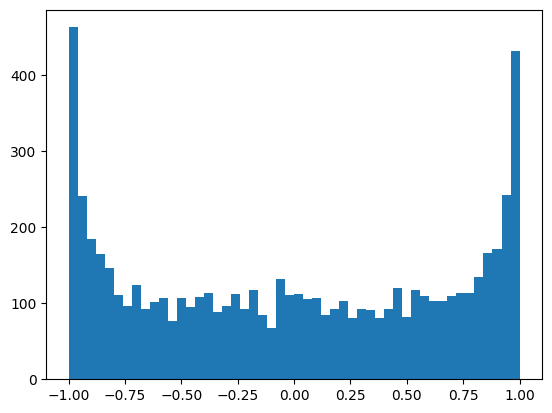

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

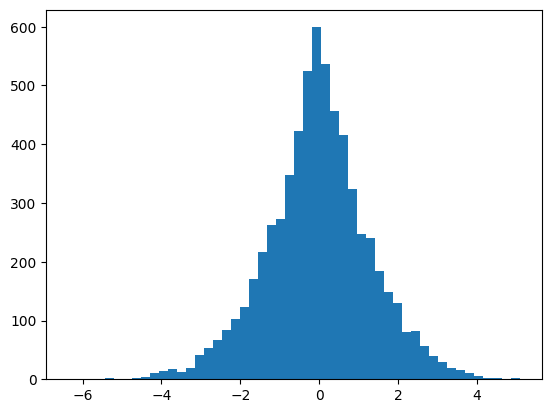

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

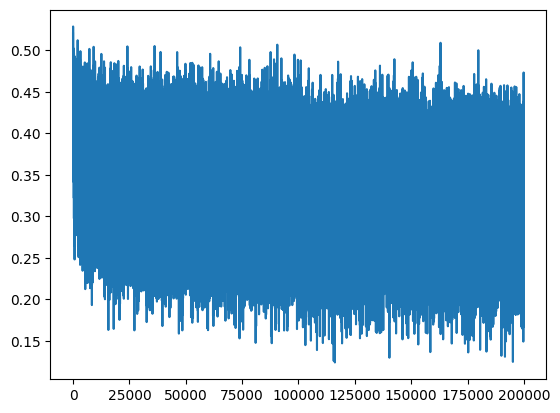

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte)
  }[split]

  emb = C[x].view(x.shape[0], -1)
  hpreact = emb @ W1 + B1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias  # Batch normalization
  h = torch.tanh(hpreact)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, y)

  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train loss: 2.0666
dev loss: 2.1051


In [60]:
## Summary

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weights = torch.rand((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weights

    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1D:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones((1, dim))
    self.beta = torch.zeros((1, dim))

    self.running_mean = torch.zeros((1, dim))
    self.running_var = torch.ones((1, dim))

  def __call__(self, x):
    if self.training:
      xmean =  x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * bnmean_running + self.momentum * bnmeani
        self.running_var = (1 - self.momentum) * bnstd_running + self.momentum * bnstdi

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(vocab_size, n_embd, generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weights *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

46497


In [61]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1) # concatenate the vectors

  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update pass
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.2933


Text(0.5, 1.0, 'activation distributions')

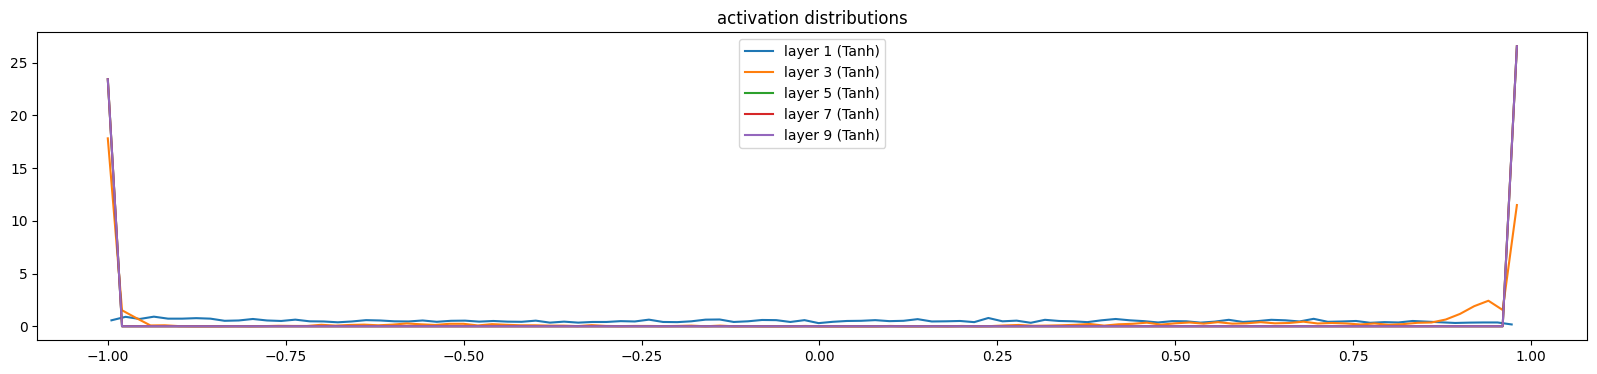

In [62]:
# visualize histograms

plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distributions')